TensorFlow version: 2.17.0

NumPy version: 1.26.4

Matplotlib version: 3.7.1

OpenCV version: 4.10.0

SciPy version: 1.14.1

Tqdm version: 4.66.5

Scikit-learn version: 1.5.2

In [12]:
!pip install scikit-learn
!pip install --upgrade scipy
!pip install tensorflow optuna numpy matplotlib scipy


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import gc
import optuna
import random
import requests
import logging
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.utils import shuffle
from scipy.linalg import sqrtm

class DataPreparation:
    def __init__(self):
        # Load the MNIST dataset
        (self.X_train, self.y_train), (self.X_test, self.y_test) = tf.keras.datasets.mnist.load_data()
        self.X_train = self.X_train.reshape(-1, 28, 28, 1)
        self.X_test = self.X_test.reshape(-1, 28, 28, 1)
        self.filters = {}

    def add_filter(self, name, filter_obj):
        self.filters[name] = filter_obj

    def apply_filters(self):
        filtered_data = {}
        for filter_name, filter_obj in self.filters.items():
            filtered_train = filter_obj.apply(self.X_train)
            filtered_train = (filtered_train.astype(np.float32) - 127.5) / 127.5
            filtered_data[filter_name] = filtered_train
        return filtered_data

    def load_PrePdata(self):
        # Normalize the test dataset
        x_test = (self.X_test.astype(np.float32) - 127.5) / 127.5

        # Apply the filters and ensure outputs have the correct dimensions
        blur_new_test = self.filters['Blur'].apply(x_test)
        bright_new_test = self.filters['Brightness'].apply(x_test)
        rotation_new_test = self.filters['Rotation'].apply(x_test)
        shift_new_test = self.filters['Shift'].apply(x_test)
        shear_new_test = self.filters['Shear'].apply(x_test)

        # Reshape all augmented datasets to 4D
        blur_new_test = blur_new_test.reshape(-1, 28, 28, 1)
        bright_new_test = bright_new_test.reshape(-1, 28, 28, 1)
        rotation_new_test = rotation_new_test.reshape(-1, 28, 28, 1)
        shift_new_test = shift_new_test.reshape(-1, 28, 28, 1)
        shear_new_test = shear_new_test.reshape(-1, 28, 28, 1)

        # Concatenate the test datasets
        x_alltrain = np.concatenate((x_test, blur_new_test, bright_new_test, rotation_new_test, shift_new_test, shear_new_test))
        y_alltrain = np.concatenate((self.y_test, self.y_test, self.y_test, self.y_test, self.y_test, self.y_test))

        # Shuffle the dataset and the labels together
        x_alltrain, y_alltrain = shuffle(x_alltrain, y_alltrain, random_state=0)

        # Reshape the training data to (num_samples, 784) for the GAN
        x_alltrain = x_alltrain.reshape(x_alltrain.shape[0], 784)

        print("Concatenated images shape:", x_alltrain.shape)
        print("Concatenated labels shape:", y_alltrain.shape)

        return x_alltrain, y_alltrain, x_test

class BlurFilter:
    def __init__(self, kernel_size=(2, 2)):
        self.kernel_size = kernel_size

    def apply(self, dataset):
        return np.array([cv2.blur(dataset[i], self.kernel_size) for i in range(dataset.shape[0])])

class BrightnessFilter:
    def __init__(self, brightness_factor=0.1):
        self.brightness_factor = brightness_factor

    def apply(self, dataset):
        adjusted_images = []
        for i in range(dataset.shape[0]):
            image = dataset[i]
            image = image / 255.0 if image.max() > 1.0 else image
            brightened = np.clip(np.where(image > 0, image + self.brightness_factor, image), 0, 1)
            brightened *= 255 if dataset.max() > 1.0 else 1
            adjusted_images.append(brightened)
        return np.array(adjusted_images)

class ShearFilter:
    def __init__(self, shear_factor_x=0.2, shear_factor_y=0.1):
        self.shear_factor_x = shear_factor_x
        self.shear_factor_y = shear_factor_y

    def apply(self, dataset):
        M = np.float32([[1, self.shear_factor_x, 0], [self.shear_factor_y, 1, 0]])
        return np.array([cv2.warpAffine(dataset[i], M, (28, 28)) for i in range(dataset.shape[0])], dtype='float32')

class ShiftFilter:
    def __init__(self, shift_factor_x=0.2, shift_factor_y=0.2):
        self.shift_factor_x = shift_factor_x
        self.shift_factor_y = shift_factor_y

    def apply(self, dataset):
        M = np.float32([[1, 0, self.shift_factor_x], [0, 1, self.shift_factor_y]])
        return np.array([cv2.warpAffine(dataset[i], M, (28, 28)) for i in range(dataset.shape[0])], dtype='float32')

class RotationFilter:
    def __init__(self, angle=5):
        self.angle = angle

    def apply(self, dataset):
        center = (dataset.shape[2] // 2, dataset.shape[1] // 2)
        return np.array([cv2.warpAffine(dataset[i], cv2.getRotationMatrix2D(center, self.angle, 1.0), (28, 28)) for i in range(dataset.shape[0])], dtype='float32')

class GAN:
    def __init__(self):
        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()
        self.gan = self.create_gan(self.generator, self.discriminator)

    def create_generator(self):
        generator = Sequential([
            Dense(256, input_dim=100),
            LeakyReLU(0.2),
            Dense(512),
            LeakyReLU(0.2),
            Dense(1024),
            LeakyReLU(0.2),
            Dense(784, activation='tanh')
        ])
        generator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
        return generator

    def create_discriminator(self):
        discriminator = Sequential([
            Dense(1024, input_dim=784),
            LeakyReLU(0.2),
            Dropout(0.3),
            Dense(512),
            LeakyReLU(0.2),
            Dropout(0.3),
            Dense(256),
            LeakyReLU(0.2),
            Dense(1, activation='sigmoid')
        ])
        discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
        return discriminator

    def create_gan(self, generator, discriminator):
        discriminator.trainable = False
        gan = Sequential([generator, discriminator])
        gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
        return gan

    def plot_generated_images(self, epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
        noise = np.random.normal(0, 1, [examples, 100])
        generated_images = self.generator.predict(noise).reshape(100, 28, 28)
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i], cmap='gray', interpolation='nearest')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'gan_generated_image_{epoch}.png')

    def save_models(self):
        # Save models
        self.gan.save(".../Paper_Diff_testing/gan_alltest2.h5")
        self.generator.save(".../Paper_Diff_testing/Generator_alltest2.h5")
        self.discriminator.save(".../Paper_Diff_testing/Discriminator_alltest2.h5", include_optimizer=True)

class GANTrainer:
    def __init__(self, data_preparation, gan_model):
        self.data_preparation = data_preparation
        self.gan_model = gan_model

    def train(self, epochs=1, batch_size=128):
        X_alltrain, Y_alltrain, _ = self.data_preparation.load_PrePdata()
        batch_count = X_alltrain.shape[0] // batch_size

        for e in range(1, epochs + 1):
            print(f"Epoch {e}")
            for _ in tqdm(range(batch_size)):
                noise = np.random.normal(0, 1, [batch_size, 100])
                generated_images = self.gan_model.generator.predict(noise)
                real_images = X_alltrain[np.random.randint(0, X_alltrain.shape[0], size=batch_size)]
                X = np.concatenate([real_images, generated_images])

                y_dis = np.zeros(2 * batch_size)
                y_dis[:batch_size] = 0.9

                self.gan_model.discriminator.trainable = True
                self.gan_model.discriminator.train_on_batch(X, y_dis)

                noise = np.random.normal(0, 1, [batch_size, 100])
                y_gen = np.ones(batch_size)

                self.gan_model.discriminator.trainable = False
                self.gan_model.gan.train_on_batch(noise, y_gen)

            if e == 1 or e % 20 == 0:
                self.gan_model.plot_generated_images(e)

        # Save models and datasets
        self.gan_model.save_models()
        np.save(".../Paper_Diff_testing/X_alltest_AStrain2.npy", X_alltrain)

# Main execution
data_prep = DataPreparation()
data_prep.add_filter("Blur", BlurFilter())
data_prep.add_filter("Brightness", BrightnessFilter())
data_prep.add_filter("Shear", ShearFilter())
data_prep.add_filter("Shift", ShiftFilter())
data_prep.add_filter("Rotation", RotationFilter())

gan = GAN()
trainer = GANTrainer(data_prep, gan)
trainer.train(epochs=500, batch_size=128)


# **Optuna: GAN Hyperparamneter Tuning**

In [ ]:

X_alltrain= np.load(".../Paper_Diff_testing/X_alltest_AStrain2.npy")

# Disable TensorFlow logging output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')


# Function to download InceptionV3 weights
def download_weights():
    url = "https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
    filename = "inception_v3_weights.h5"
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)


# Check if InceptionV3 weights are downloaded, if not, download them
if not os.path.exists("inception_v3_weights.h5"):
    download_weights()

# Load InceptionV3 model for FID , KID
inception = InceptionV3(include_top=False, pooling='avg')
inception.load_weights("inception_v3_weights.h5")


# Function to scale images between -1 and 1
def scale_to_minus_one_one(array):
    max_val = np.max(array)
    min_val = np.min(array)
    scaled_array = (array - min_val) / (max_val - min_val)
    scaled_array = (scaled_array * 2) - 1
    return scaled_array


def polynomial_kernel(x, y, degree=3, gamma=None, coef0=1):
    if gamma is None:
        gamma = 1.0 / x.shape[1]
    return (gamma * np.dot(x, y.T) + coef0) ** degree


# Calculate KID score
def calculate_kid(real_images, generated_images, degree=3):
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))
    if real_images_resized.shape[-1] == 1:
        real_images_resized = tf.repeat(real_images_resized, 3, axis=-1)
    if generated_images_resized.shape[-1] == 1:
        generated_images_resized = tf.repeat(generated_images_resized, 3, axis=-1)

    # Extract features using InceptionV3
    real_features = inception.predict(preprocess_input(real_images_resized))
    generated_features = inception.predict(preprocess_input(generated_images_resized))

    kernel_real = polynomial_kernel(real_features, real_features, degree=degree)
    kernel_gen = polynomial_kernel(generated_features, generated_features, degree=degree)
    kernel_real_gen = polynomial_kernel(real_features, generated_features, degree=degree)

    # Calculate KID
    m = real_features.shape[0]
    n = generated_features.shape[0]
    kid = (np.sum(kernel_real) / (m * (m - 1)) +
           np.sum(kernel_gen) / (n * (n - 1)) -
           2 * np.sum(kernel_real_gen) / (m * n))
    return kid


# FID score
def calculate_fid(real_images, generated_images):
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    if real_images_resized.shape[-1] == 1:
        real_images_resized = tf.repeat(real_images_resized, 3, axis=-1)
    if generated_images_resized.shape[-1] == 1:
        generated_images_resized = tf.repeat(generated_images_resized, 3, axis=-1)

    real_features = inception.predict(preprocess_input(real_images_resized))
    generated_features = inception.predict(preprocess_input(generated_images_resized))

    # Calculate FID
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


# Function to create the optimizer for Optuna trial
def adam_optimizer(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    beta_1 = trial.suggest_float("beta_1", 0.1, 0.9)
    return Adam(learning_rate=learning_rate, beta_1=beta_1)


# Create the generator model
def create_generator(optimizer):
    generator = Sequential([
        layers.Dense(256, input_dim=100),
        LeakyReLU(0.2),
        layers.Dense(512),
        LeakyReLU(0.2),
        layers.Dense(1024),
        LeakyReLU(0.2),
        layers.Dense(784, activation='tanh')
    ])
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator


# Discriminator model
def create_discriminator(optimizer):
    discriminator = Sequential([
        layers.Dense(1024, input_dim=784),
        LeakyReLU(0.2),
        Dropout(0.3),
        layers.Dense(512),
        LeakyReLU(0.2),
        Dropout(0.3),
        layers.Dense(256),
        LeakyReLU(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


# GAN model
def create_gan(discriminator, generator, optimizer):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan


# Train GAN in Optuna trial
def objective(trial):
    optimizer = adam_optimizer(trial)
    generator = create_generator(optimizer)
    discriminator = create_discriminator(optimizer)
    gan = create_gan(discriminator, generator, optimizer)

    epochs = 400
    batch_size = 128

    for e in range(epochs):
        for _ in range(batch_size):
            noise = np.random.normal(0, 1, [batch_size, 100])
            generated_images = generator.predict(noise)

            # Get a random set of real images
            image_batch = X_alltrain[np.random.randint(0, X_alltrain.shape[0], size=batch_size)]
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9

            # Train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train the GAN
            noise = np.random.normal(0, 1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e % 50 == 0:
            print(f"Epoch {e}/{epochs}")

    # Evaluate model performance using FID and KID
    fid_scores = []
    kid_scores = []
    num_samples = 100
    num_runs = 10

    for _ in range(num_runs):
        indices = np.random.choice(len(X_alltrain), size=num_samples, replace=False)
        real_images_subset = X_alltrain[indices].reshape(num_samples, 28, 28, 1)
        noise = np.random.normal(0, 1, [num_samples, 100])
        generated_images = generator.predict(noise)

        real_images_subset = tf.convert_to_tensor(real_images_subset)
        generated_images = tf.convert_to_tensor(generated_images.reshape(num_samples, 28, 28, 1))

        fid_scores.append(calculate_fid(real_images_subset, generated_images))
        kid_scores.append(calculate_kid(real_images_subset, generated_images))

    avg_fid = np.mean(fid_scores)
    avg_kid = np.mean(kid_scores)

    print(f"Avg FID: {avg_fid}, Avg KID: {avg_kid}")

    # Cleanup
    del generator, discriminator, gan
    gc.collect()

    return avg_fid, avg_kid


# Optuna study configuration
n_trials = 5
study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=n_trials)

# Display the best trials and parameters
best_trials = study.best_trials
for i, trial in enumerate(best_trials):
    print(f"Best Hyperparameters for Trial {i+1}: {trial.params}")
    print(f"Best Objective Values for Trial {i+1}: {trial.values}")

def plot_trial_results(study):
    trial_numbers = range(1, len(study.trials) + 1)
    fid_scores, kid_scores = [], []

    for trial in study.trials:
        fid_scores.append(trial.values[0])
        kid_scores.append(trial.values[1])

    # FID scores
    plt.figure(figsize=(10, 5))
    plt.plot(trial_numbers, fid_scores, marker='o')
    plt.xlabel('Trial Number')
    plt.ylabel('FID Score')
    plt.title('FID Scores vs. Trial Number')
    plt.grid(True)
    plt.show()

    # Plot KID scores
    plt.figure(figsize=(10, 5))
    plt.plot(trial_numbers, kid_scores, marker='o')
    plt.xlabel('Trial Number')
    plt.ylabel('KID Score')
    plt.title('KID Scores vs. Trial Number')
    plt.grid(True)
    plt.show()

plot_trial_results(study)


# **Training DNN Models (Scenarios)**
just example of Model 7 and 8 training

In [14]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

####################################################################
# Loading and Preprocessing the MNIST Dataset
####################################################################

def load_and_prepare_dataMNIST():
    (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

    # Normalize pixel values to be between 0 and 1
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # Reshape images to include channel dimension
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

    # One-hot encode labels
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)

    return (train_images, train_labels), (test_images, test_labels)

####################################################################
# AlexNet-like Model Definition
####################################################################

def create_alexnet_model(input_shape, num_classes=10):
    model = models.Sequential()
    model.add(layers.Conv2D(96, (3, 3), strides=1, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

####################################################################
# Model Compilation and Training
####################################################################

def compile_and_train_model(model, train_images, train_labels, test_images, test_labels, learning_rate, epochs, batch_size):
    # Create an Adam optimizer with the custom learning rate
    adam_optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    # Train the model
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

####################################################################
# Load Pre-trained Models and Compare Predictions
####################################################################

def compare_models_on_test_data(x_test, y_test):
    # Load the first pre-trained model
    model1 = tf.keras.models.load_model('.../Paper_Diff_testing/DNN_Models/mnist_Model1.h5')

    # Load the second pre-trained model
    model2 = tf.keras.models.load_model('.../Paper_Diff_testing/DNN_Models/mnist_Model2.h5')

    # Predict using both models
    predictions1 = model1.predict(x_test)
    predictions2 = model2.predict(x_test)

    # Find the indices where the models disagree
    different_indices = np.where(np.argmax(predictions1, axis=1) != np.argmax(predictions2, axis=1))[0]
    print('Test images with different predictions:', different_indices)

    # Evaluate both models on the test set
    loss1, accuracy1 = model1.evaluate(x_test, y_test, verbose=0)
    loss2, accuracy2 = model2.evaluate(x_test, y_test, verbose=0)

    print('Model 1 Accuracy: %.2f%%' % (accuracy1 * 100))
    print('Model 2 Accuracy: %.2f%%' % (accuracy2 * 100))

####################################################################
# Main Script: Training Models and Comparing Pre-trained Models
####################################################################

if __name__ == "__main__":
    # Load and prepare MNIST data
    (train_images, train_labels), (test_images, test_labels) = load_and_prepare_dataMNIST()

    # Train the first AlexNet-like model
    model1 = create_alexnet_model(input_shape=(28, 28, 1), num_classes=10)
    compile_and_train_model(model1, train_images, train_labels, test_images, test_labels, learning_rate=0.00001, epochs=9, batch_size=128)
    model1.save('.../Paper_Diff_testing/DNN_Models/mnist_Model1.h5')
    # Train the second AlexNet-like model
    model2 = create_alexnet_model(input_shape=(28, 28, 1), num_classes=10)
    compile_and_train_model(model2, train_images, train_labels, test_images, test_labels, learning_rate=0.0001, epochs=14, batch_size=256)

    model2.save('.../Paper_Diff_testing/DNN_Models/mnist_Model2.h5')
    # Load and compare pre-trained models
    compare_models_on_test_data(test_images, test_labels)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 96)          │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,733,898 (94.35 MB)

 Trainable params: 24,733,898 (94.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.5906 - loss: 1.4478 - val_accuracy: 0.9481 - val_loss: 0.1815
Epoch 2/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9468 - loss: 0.1797 - val_accuracy: 0.9642 - val_loss: 0.1124
Epoch 3/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9640 - loss: 0.1182 - val_accuracy: 0.9728 - val_loss: 0.0863
Epoch 4/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9722 - loss: 0.0912 - val_accuracy: 0.9802 - val_loss: 0.0619
Epoch 5/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9765 - loss: 0.0779 - val_accuracy: 0.9810 - val_loss: 0.0544
Epoch 6/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9803 - loss: 0.0611 - val_accuracy: 0.9843 - val_loss: 0.0472
Epoch 7/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9829 - loss: 0.0567 - val_accuracy: 0.9852 - val_loss: 0.0433
Epoch 8/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9844 -

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 96)          │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,733,898 (94.35 MB)

 Trainable params: 24,733,898 (94.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7327 - loss: 0.8255 - val_accuracy: 0.9726 - val_loss: 0.0797
Epoch 2/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9757 - loss: 0.0805 - val_accuracy: 0.9878 - val_loss: 0.0360
Epoch 3/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9856 - loss: 0.0469 - val_accuracy: 0.9879 - val_loss: 0.0379
Epoch 4/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9891 - loss: 0.0343 - val_accuracy: 0.9909 - val_loss: 0.0272
Epoch 5/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9919 - loss: 0.0255 - val_accuracy: 0.9907 - val_loss: 0.0259
Epoch 6/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9926 - loss: 0.0230 - val_accuracy: 0.9938 - val_loss: 0.0184
Epoch 7/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9938 - loss: 0.0178 - val_accuracy: 0.9913 - val_loss: 0.0264
Epoch 8/14
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '.../Paper_Diff_testing/DNN_Models/mnist_Model1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Example of Model 5 structure (MNIST)

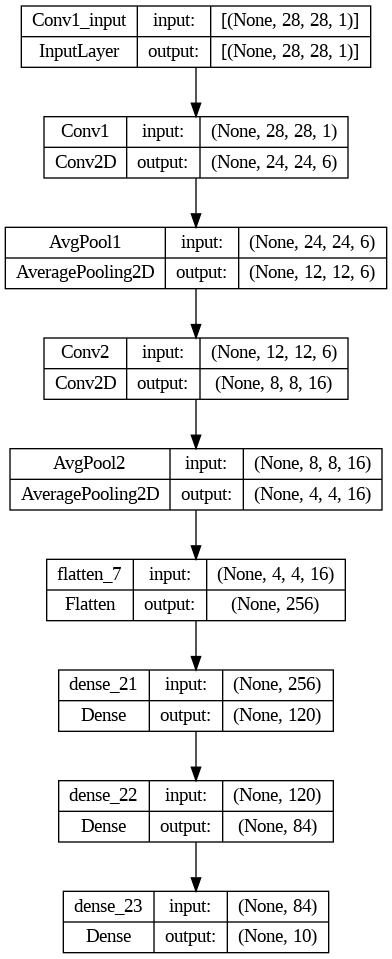

In [ ]:
plot_model(model5, show_shapes=True, to_file='MNIST_LeNet5.png')

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib
import cv2
import scipy
import tqdm
import sklearn

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("OpenCV version:", cv2.__version__)
print("SciPy version:", scipy.__version__)
print("Tqdm version:", tqdm.__version__)
print("Scikit-learn version:", sklearn.__version__)


TensorFlow version: 2.17.0
NumPy version: 1.26.4
Matplotlib version: 3.7.1
OpenCV version: 4.10.0
SciPy version: 1.14.1
Tqdm version: 4.66.5
Scikit-learn version: 1.5.2
